In [114]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
import re
import os
import seaborn as sns
from matplotlib import cm, colors

In [115]:
PATH = os.getcwd()
TEST_FOLDER = 'test-result'
REGGRESSION_FOLDER = 'regressions'
PARAMETRIC_FOLDER = 'parametric'
ACENTUACION_FOLDER = 'Acentuacion'
CADENCIA_FOLDER = 'Cadencia'
INTELIGIBILIDAD_FOLDER = 'Inteligibilidad'
NATURALIDAD_FOLDER = 'Naturalidad'
PRONUNCIACION_FOLDER = 'Pronunciacion'
MALE_FOLDER = 'masculino'
FEMALE_FOLDER = 'femenino'

In [116]:
# Diccionario para guardar los p-value
dicc_p_value = {
    'subjetive_parameter':[],
    'ZCR':[],
    'RMS':[],
    'f0':[],
    'selected_features':[],
    'shapiro_wilk_test':[],
    'genero':[] 
}

In [117]:
# Voy a limpiar los graficos que hay en las carpetas

list_files = os.listdir(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER))

list_folder = []
for folder in list_files:
    if not folder.endswith('.xlsx'):
        list_folder.append(folder)
        
SUBFOLDER_GENDER = ['masculino', 'femenino']

for folder in list_folder:
    for gender in SUBFOLDER_GENDER:
        os.chdir(os.path.join(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, folder, gender)))
        all_files = os.listdir()
        if len(all_files) == 0:
            continue
        for f in all_files:
            os.remove(f)

os.chdir(PATH)

In [118]:
list_folder

['Acentuacion', 'Cadencia', 'Inteligibilidad', 'Naturalidad', 'Pronunciacion']

In [119]:
merged_df = pd.read_csv(r'aux_file\data_regression.csv')

In [120]:
obj_params = pd.read_excel('voces_test_rms.ods')

In [121]:
obj_params.head()

,zero_crossing_rate,rms,mfcc,pitch,genero,file
0,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino,hyacinthe-lovo-v3.wav
1,0.093035,-27.0,[-424.61664 138.61742 -14.495688 3...,101.312090,femenino,lola-murf.wav
2,0.093043,-22.5,[-3.71418152e+02 1.31561859e+02 -1.60284328e+...,76.492752,masculino,neural2B-GCP.wav
3,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino,alonso-naturalreader.wav
4,0.105458,-21.5,[-3.5115176e+02 1.1943483e+02 -1.9279911e+01 ...,69.045778,masculino,antonio-murf.wav


In [122]:
df_union = pd.merge(
    merged_df,
    obj_params,
    how='left',
    left_on='filename',
    right_on='file'
).drop(columns=['file'])

In [123]:
df_union.rename(
    columns={
        'zero_crossing_rate': 'zcr',
        'pitch': 'f0'
    },
    inplace=True
)

In [124]:
df_union.head()

,ID,filename,Inteligibilidad,Pronunciacion,Acentuacion,Naturalidad,Cadencia,zcr,rms,mfcc,f0,genero
0,1,alonso-naturalreader.wav,4.867647,4.621212,4.426471,3.250000,3.823529,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino
1,2,hyacinthe-lovo-v3.wav,4.970588,4.692308,4.602941,4.308824,4.250000,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino
2,3,neural2C-pitchmodified-speedmodified.wav,4.515625,3.962963,2.852941,1.779412,1.720588,0.251626,-25.0,[-4.4141333e+02 8.9362648e+01 -1.2164741e+01 ...,98.468505,masculino
3,4,francisca-lovo-v2.wav,4.746269,4.276923,4.294118,3.220588,3.823529,0.137822,-26.1,[-454.8679 72.41395 -14.8625145 45.9...,116.353345,femenino
4,5,antoni-evenlabs-linguistico-v2.wav,4.681818,4.064516,3.220588,1.897059,1.779412,0.239188,-24.0,[-406.19888 84.30505 -12.89493 18.8...,78.968152,masculino


## SelectorFeature

In [125]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.utils import check_random_state
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
from scipy import stats

In [126]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """Un envoltorio para hacer que los modelos de regresión de statsmodels sean compatibles con la API de scikit-learn"""
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.model = None

    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model = self.model_class(y, X)
        self.results = self.model.fit()
        return self.results

    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results.predict(X)

### Inteligibilidad

In [127]:
df_inteligibilidad = df_union.loc[:, ['Inteligibilidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [128]:
# Lista de p-values
p_values = []

mask_gender = df_inteligibilidad.genero == 'masculino'

df_inteligibilidad_male = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [129]:
# Cargamos los datos
X = np.array(df_inteligibilidad_male.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_male.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
  
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    
dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)


Coeficiente de determinación R^2: 0.5392
Shapiro-Wilk p-valor: 0.5369030833244324
Características seleccionadas: (0,)
Característica Seleccionada ZCR: p-valor = 0.0156

Característica ZCR: p-valor = 0.1397
Característica RMS: p-valor = 0.4971
Característica f0: p-valor = 0.6041


In [130]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [131]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -2.32 * ZCR + 5.05 - p-valor = 0.016 - R$^2$ = 0.539


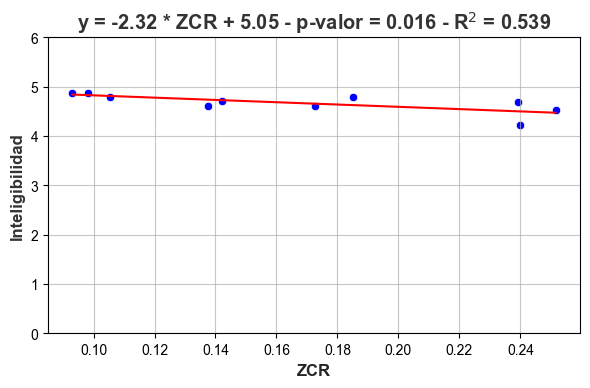

In [132]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresiones_inteligibilidad_male.png'))
    plt.show()


In [133]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=axis_name_list[0], yaxis_title=axis_name_list[1], zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-28, -26, -24, -22])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresion_inteligibilidad_multivariable_male.html')
    )
    
    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresion_inteligibilidad_multivariable_male.png')
    )


    fig.show()


#### Femenino

In [134]:
# Lista de p-values
p_values = []

mask_gender = df_inteligibilidad.genero == 'femenino'

df_inteligibilidad_female = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [135]:
# Cargamos los datos
X = np.array(df_inteligibilidad_female.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_female.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)


Coeficiente de determinación R^2: 0.8008
Shapiro-Wilk p-valor: 0.5264934301376343
Características seleccionadas: (0, 2)
Característica Seleccionada ZCR: p-valor = 0.0015
Característica Seleccionada f0: p-valor = 0.0386

Característica ZCR: p-valor = 0.0324
Característica RMS: p-valor = 0.6260
Característica f0: p-valor = 0.0539


In [136]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [137]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -2.26 * ZCR + 5.09 - p-valor = 0.002
y = -0.01 * $f_{0}$ + 5.29 - p-valor = 0.039


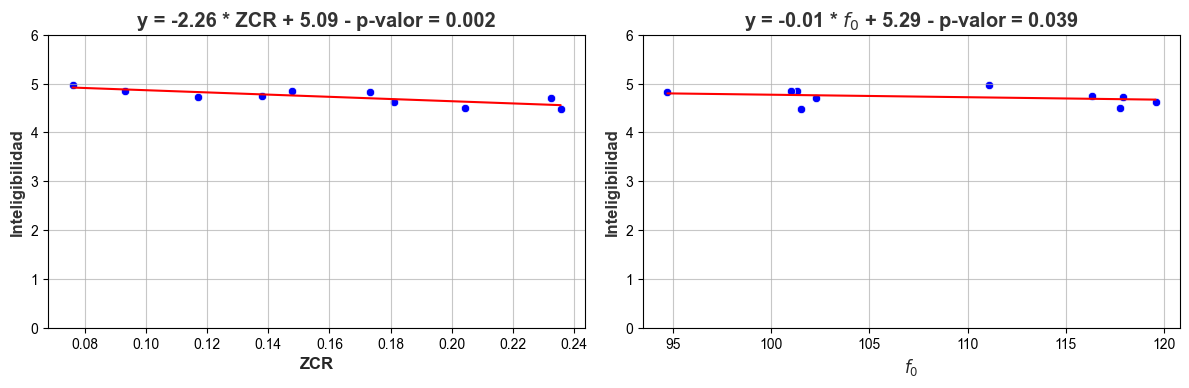

In [138]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(
        os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_inteligibilidad_female.png')
    )
    plt.show()


In [139]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))


    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name}'
        
    equation += f' - R² = {r_squared_value:.3f}'
     
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))
        

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=axis_name_list[0], yaxis_title=axis_name_list[1], zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresion_inteligibilidad_multivariable_female.html')
    )
    
    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresion_inteligibilidad_multivariable_female.png')
    )


    fig.show()


### Pronunciacion

In [140]:
df_pronunciacion = df_union.loc[:, ['Pronunciacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [141]:
# Lista de p-values
p_values = []

mask_gender = df_pronunciacion.genero == 'masculino'

df_pronunciacion_male = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [142]:
# Cargamos los datos
X = np.array(df_pronunciacion_male.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_male.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')


dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)


Coeficiente de determinación R^2: 0.7798
Shapiro-Wilk p-valor: 0.10431306064128876
Características seleccionadas: (0, 1)
Característica Seleccionada ZCR: p-valor = 0.0028
Característica Seleccionada RMS: p-valor = 0.0459

Característica ZCR: p-valor = 0.0077
Característica RMS: p-valor = 0.0483
Característica f0: p-valor = 0.3416


In [143]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [144]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -3.07 * ZCR + 4.81 - p-valor = 0.003
y = 0.06 * RMS + 5.69 - p-valor = 0.046


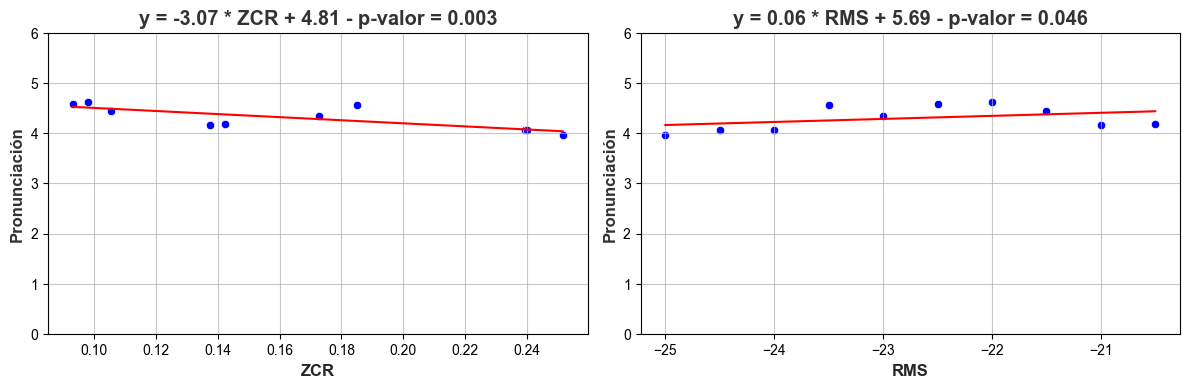

In [145]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresiones_pronunciacion_male.png'))
    plt.show()


In [146]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=axis_name_list[0], yaxis_title=axis_name_list[1], zaxis_title='Pronunciación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-24, -23, -22, -21])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresion_pronunciacion_multivariable_male.html')
    )

    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresion_pronunciacion_multivariable_male.png')
    )

    fig.show()


#### Femenino

In [147]:
# Lista de p-values
p_values = []

mask_gender = df_pronunciacion.genero == 'femenino'

df_pronunciacion_female = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [148]:
# Cargamos los datos
X = np.array(df_pronunciacion_female.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_female.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)


Coeficiente de determinación R^2: 0.6758
Shapiro-Wilk p-valor: 0.019548965618014336
Características seleccionadas: (0, 2)
Característica Seleccionada ZCR: p-valor = 0.0120
Característica Seleccionada f0: p-valor = 0.0524

Característica ZCR: p-valor = 0.1217
Característica RMS: p-valor = 0.7014
Característica f0: p-valor = 0.0722


In [149]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [150]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -2.51 * ZCR + 4.79 - p-valor = 0.012
y = -0.01 * $f_{0}$ + 5.37 - p-valor = 0.052


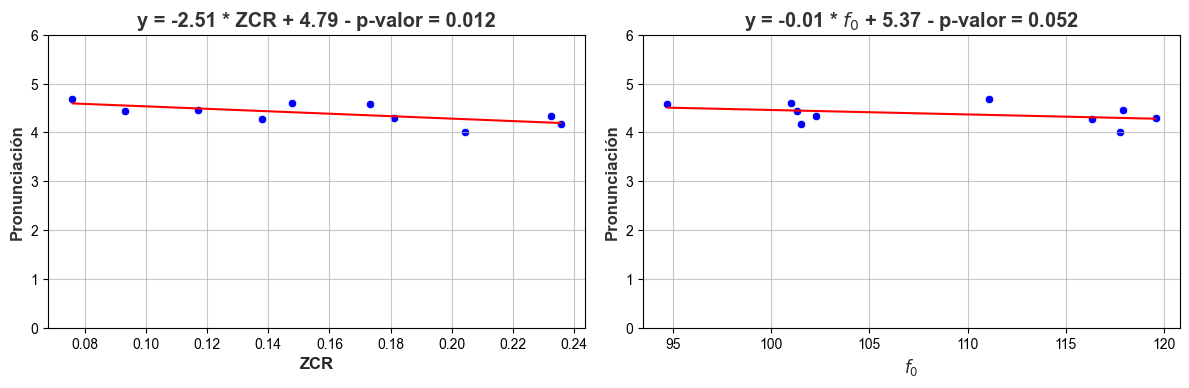

In [151]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresiones_pronunciacion_female.png'))
    plt.show()


In [152]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=axis_name_list[0], yaxis_title=axis_name_list[1], zaxis_title='Pronunciación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresion_pronunciacion_multivariable_female.html')
    )
    
    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresion_pronunciacion_multivariable_female.png')
    )

    fig.show()


### Acentuacion

In [153]:
df_acentuacion = df_union.loc[:, ['Acentuacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [154]:
# Lista de p-values
p_values = []

mask_gender = df_acentuacion.genero == 'masculino'

df_acentuacion_male = df_acentuacion[mask_gender].drop(columns=['genero'])

In [155]:
# Cargamos los datos
X = np.array(df_acentuacion_male.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_male.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')


dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)


Coeficiente de determinación R^2: 0.6890
Shapiro-Wilk p-valor: 0.8480933904647827
Características seleccionadas: (0,)
Característica Seleccionada ZCR: p-valor = 0.0030

Característica ZCR: p-valor = 0.0168
Característica RMS: p-valor = 0.1353
Característica f0: p-valor = 0.3779


In [156]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [157]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -8.08 * ZCR + 5.08 - p-valor = 0.003 - R$^2$ = 0.689


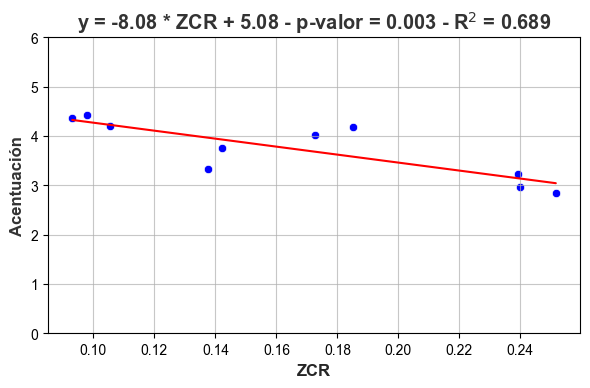

In [158]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresiones_acentuacion_male.png'))
    plt.show()


In [159]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=axis_name_list[0], yaxis_title=axis_name_list[1], zaxis_title='Acentuación', zaxis=dict(range=[0, 6])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresion_acentuacion_multivariable_male.html')
    )
    
    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresion_acentuacion_multivariable_male.png')
    )

    fig.show()


#### Femenino

In [160]:
# Lista de p-values
p_values = []

mask_gender = df_acentuacion.genero == 'femenino'

df_acentuacion_female = df_acentuacion[mask_gender].drop(columns=['genero'])

In [161]:
# Cargamos los datos
X = np.array(df_acentuacion_female.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_female.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)


Coeficiente de determinación R^2: 0.5348
Shapiro-Wilk p-valor: 0.9564486742019653
Características seleccionadas: (1, 2)
Característica Seleccionada RMS: p-valor = 0.0521
Característica Seleccionada f0: p-valor = 0.1067

Característica ZCR: p-valor = 0.4835
Característica RMS: p-valor = 0.3797
Característica f0: p-valor = 0.1105


In [162]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [163]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = 0.18 * RMS + 9.16 - p-valor = 0.052
y = -0.02 * $f_{0}$ + 6.52 - p-valor = 0.107


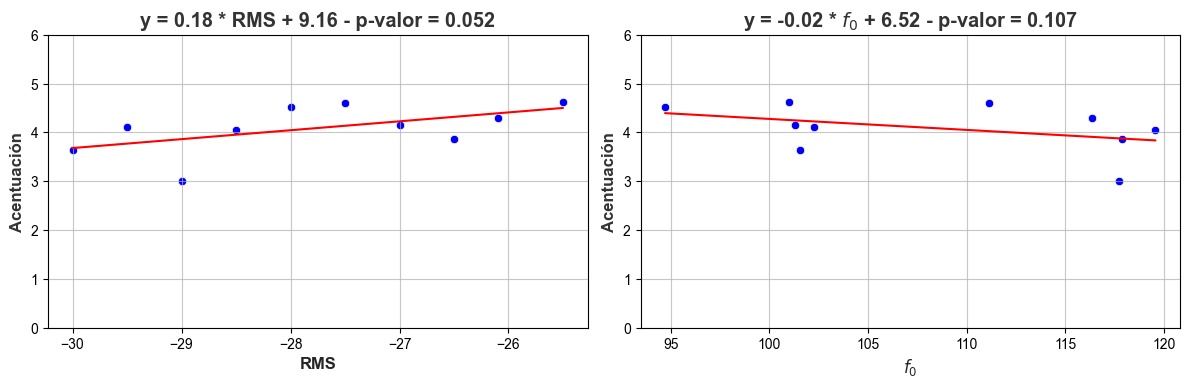

In [164]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresiones_acentuacion_female.png'))
    plt.show()


In [165]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=axis_name_list[0], yaxis_title=axis_name_list[1], zaxis_title='Acentuación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresion_acentuacion_multivariable_female.html')
    )

    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresion_acentuacion_multivariable_female.png')
    )

    fig.show()


### Naturalidad

In [166]:
df_naturalidad = df_union.loc[:, ['Naturalidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [167]:
# Lista de p-values
p_values = []

mask_gender = df_naturalidad.genero == 'masculino'

df_naturalidad_male = df_naturalidad[mask_gender].drop(columns=['genero'])

In [168]:
# Cargamos los datos
X = np.array(df_naturalidad_male.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_male.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')


dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)


Coeficiente de determinación R^2: 0.8144
Shapiro-Wilk p-valor: 0.9401729702949524
Características seleccionadas: (0,)
Característica Seleccionada ZCR: p-valor = 0.0004

Característica ZCR: p-valor = 0.0144
Característica RMS: p-valor = 0.9226
Característica f0: p-valor = 0.7219


In [169]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [170]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared

    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -11.44 * ZCR + 4.66 - p-valor = 0.000 - R$^2$ = 0.814


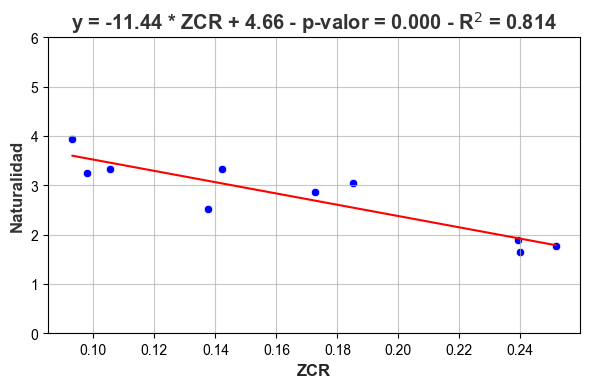

In [171]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresiones_naturalidad_male.png'))
    plt.show()


In [172]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=axis_name_list[0], yaxis_title=axis_name_list[1], zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-24, -23, -22, -21])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresion_naturalidad_multivariable_male.html')
    )
    
    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresion_naturalidad_multivariable_male.png')
    )

    fig.show()


#### Femenino

In [173]:
# Lista de p-values
p_values = []

mask_gender = df_naturalidad.genero == 'femenino'

df_naturalidad_female = df_naturalidad[mask_gender].drop(columns=['genero'])

In [174]:
# Cargamos los datos
X = np.array(df_naturalidad_female.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_female.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)


Coeficiente de determinación R^2: 0.6409
Shapiro-Wilk p-valor: 0.026250893250107765
Características seleccionadas: (1, 2)
Característica Seleccionada RMS: p-valor = 0.0141
Característica Seleccionada f0: p-valor = 0.1263

Característica ZCR: p-valor = 0.1165
Característica RMS: p-valor = 0.3008
Característica f0: p-valor = 0.0680


In [175]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [176]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = 0.36 * RMS + 13.09 - p-valor = 0.014
y = -0.03 * $f_{0}$ + 6.07 - p-valor = 0.126


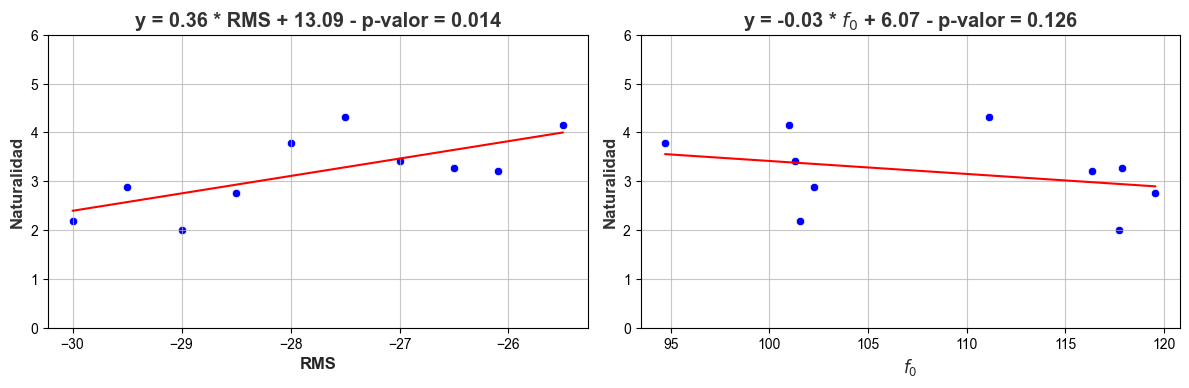

In [177]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_naturalidad_female.png'))
    plt.show()


In [178]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=axis_name_list[0], yaxis_title=axis_name_list[1], zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresion_naturalidad_multivariable_female.html')
    )

    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresion_naturalidad_multivariable_female.png')
    )


    fig.show()


### Cadencia

In [179]:
df_cadencia = df_union.loc[:, ['Cadencia', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [180]:
# Lista de p-values
p_values = []

mask_gender = df_cadencia.genero == 'masculino'

df_cadencia_male = df_cadencia[mask_gender].drop(columns=['genero'])

In [181]:
# Cargamos los datos
X = np.array(df_cadencia_male.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_male.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')


dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)


Coeficiente de determinación R^2: 0.8347
Shapiro-Wilk p-valor: 0.6572168469429016
Características seleccionadas: (0,)
Característica Seleccionada ZCR: p-valor = 0.0002

Característica ZCR: p-valor = 0.0036
Característica RMS: p-valor = 0.2866
Característica f0: p-valor = 0.8908


In [182]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [183]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -13.5 * ZCR + 5.1 - p-valor = 0.000 - R$^2$ = 0.835


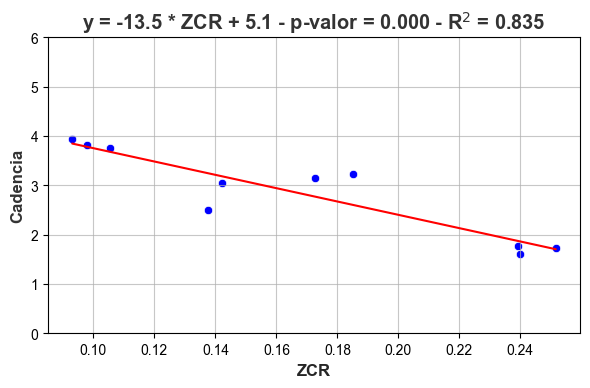

In [184]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresiones_cadencia_male.png'))
    plt.show()


In [185]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=axis_name_list[0], yaxis_title=axis_name_list[1], zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[75, 80, 85, 90, 95])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresion_cadencia_multivariable_male.html')
    )

    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresion_cadencia_multivariable_male.png')
    )

    fig.show()


#### Femenino

In [186]:
# Lista de p-values
p_values = []

mask_gender = df_cadencia.genero == 'femenino'

df_cadencia_female = df_cadencia[mask_gender].drop(columns=['genero'])

In [187]:
# Cargamos los datos
X = np.array(df_cadencia_female.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_female.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)


Coeficiente de determinación R^2: 0.8850
Shapiro-Wilk p-valor: 0.8104830980300903
Características seleccionadas: (0, 1, 2)
Característica Seleccionada ZCR: p-valor = 0.0800
Característica Seleccionada RMS: p-valor = 0.0495
Característica Seleccionada f0: p-valor = 0.0197

Característica ZCR: p-valor = 0.0800
Característica RMS: p-valor = 0.0495
Característica f0: p-valor = 0.0197


In [188]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [189]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[idx]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -10.88 * ZCR + 5.13 - p-valor = 0.080
y = 0.42 * RMS + 15.17 - p-valor = 0.049
y = -0.03 * $f_{0}$ + 6.38 - p-valor = 0.020


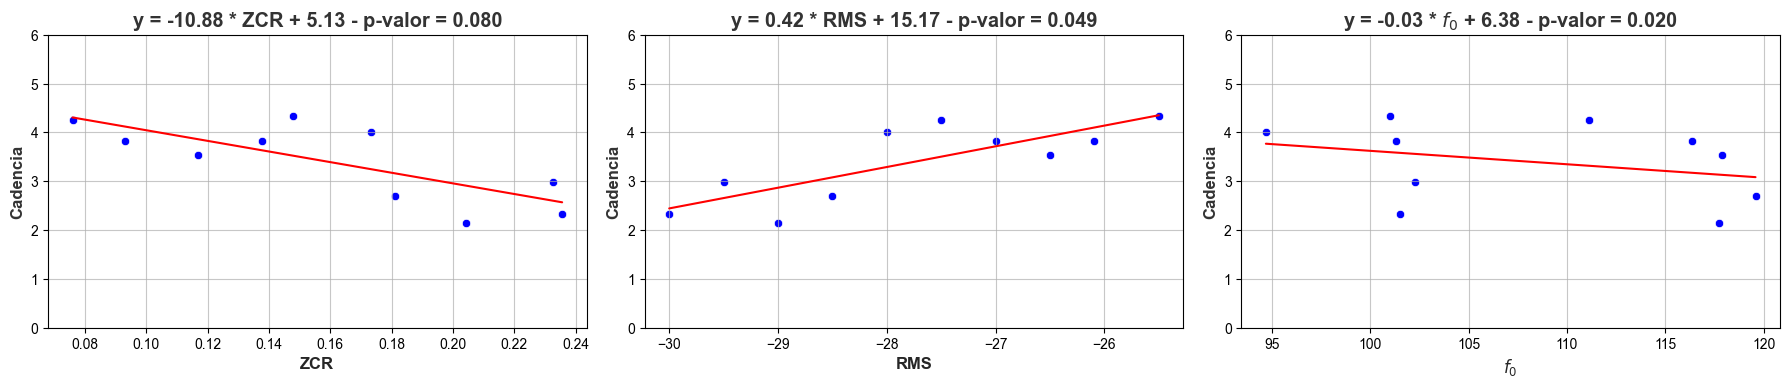

In [190]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresiones_cadencia_female.png'))
    plt.show()


In [191]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=axis_name_list[0], yaxis_title=axis_name_list[1], zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115, 120])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresion_cadencia_multivariable_female.html')
    )

    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresion_cadencia_multivariable_female.png')
    )

    fig.show()

## Output p-values regressions

In [192]:
df_output_p_value_regression = pd.DataFrame(dicc_p_value)

In [193]:
# Crea un diccionario para mapear los valores
map_dict = {0: 'ZCR', 1: 'RMS', 2: 'F0'}

df_output_p_value_regression['selected_features'] = df_output_p_value_regression['selected_features'].apply(lambda x: [map_dict[val] for val in x])

df_output_p_value_regression.fillna('-', inplace=True)

C:\Users\lnard\AppData\Local\Temp\ipykernel_7652\138939346.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [194]:
df_output_p_value_regression['shapiro_wilk_test_result'] = df_output_p_value_regression.shapiro_wilk_test.apply(
    lambda x: 'No hay evidencia suficiente para afirmar que los residuos no se distribuyen normalmente' if x > 0.05
    else 'Hay evidencia suficiente para afirmar que los residuos no se distribuyen normalmente'
)

In [195]:
df_output_p_value_regression

,subjetive_parameter,ZCR,RMS,f0,selected_features,shapiro_wilk_test,genero,shapiro_wilk_test_result
0,Inteligibilidad,0.015597,-,-,[ZCR],0.536903,masculino,No hay evidencia suficiente para afirmar que l...
1,Inteligibilidad,0.001549,-,0.03856,"[ZCR, F0]",0.526493,femenino,No hay evidencia suficiente para afirmar que l...
2,Pronunciación,0.002814,0.045937,-,"[ZCR, RMS]",0.104313,masculino,No hay evidencia suficiente para afirmar que l...
3,Pronunciación,0.012001,-,0.05237,"[ZCR, F0]",0.019549,femenino,Hay evidencia suficiente para afirmar que los ...
4,Acentuación,0.002956,-,-,[ZCR],0.848093,masculino,No hay evidencia suficiente para afirmar que l...
5,Acentuación,-,0.052149,0.10671,"[RMS, F0]",0.956449,femenino,No hay evidencia suficiente para afirmar que l...
6,Naturalidad,0.000351,-,-,[ZCR],0.940173,masculino,No hay evidencia suficiente para afirmar que l...
7,Naturalidad,-,0.014109,0.12627,"[RMS, F0]",0.026251,femenino,Hay evidencia suficiente para afirmar que los ...
8,Cadencia,0.000219,-,-,[ZCR],0.657217,masculino,No hay evidencia suficiente para afirmar que l...
9,Cadencia,0.080017,0.049479,0.019715,"[ZCR, RMS, F0]",0.810483,femenino,No hay evidencia suficiente para afirmar que l...


In [196]:
df_output_p_value_regression.to_excel(
    os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, 'output_p_values_parametric_regressions.xlsx'),
    index=False
)